# Assignment 2

## Project 3 – Captcha decoding

## Faculty of Engineering - University of Porto
## Computer Vision [M.EEC034]

### Matheus Yasuo Ribeiro Utino - up202211693 - up202211693@up.pt

## Introduction

Captchas are a commonly encountered online security measure designed to distinguish between human users and automated bots or malicious software. The term "captcha" stands for "Completely Automated Public Turing test to tell Computers and Humans Apart."

Captchas typically consist of distorted or obscured images, letters, numbers, or a combination of these, presented in a way that is difficult for automated programs to decipher accurately. Users are usually required to enter the characters shown in the captcha field to prove that they are human.

The purpose of captchas is to prevent automated bots from abusing online services or attempting to gain unauthorized access. By requiring users to complete a captcha, websites and online platforms can verify that the interaction is being carried out by a human, thus ensuring security and protecting against spam, brute force attacks, and other forms of automated abuse.

While captchas can sometimes be frustrating or challenging to complete accurately, they serve an important role in maintaining the security and integrity of online systems, helping to ensure a safer and more reliable online experience for users.

In this way, our goal is to solve captchas using deep learning, specifically Convolutional Neural Networks (CNNs), which are robust models for object detection. During this process, the methods and ideas employed will be explained, as well as the analysis of the obtained results. Finally, the attempted methods that did not yield good results will be discussed, along with the limitations of the utilized method, and some ideas that may enhance the model's performance. Lastly, a conclusion regarding this challenge will be provided.

## Loading data

In [ ]:
# Download data from public google colab
!gdown "1S1HYV9VSBz87tkdgYUoGvXiECuTG-sey"

Downloading...
From: https://drive.google.com/uc?id=1S1HYV9VSBz87tkdgYUoGvXiECuTG-sey
To: /content/CAPTCHA_dataset.zip
100% 116M/116M [00:03<00:00, 34.3MB/s]


In [ ]:
# Unzip the data
!unzip CAPTCHA_dataset.zip -d CAPTCHA_dataset

A saída de streaming foi truncada nas últimas 5000 linhas.
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/34940.png  
  inflating: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/34hn.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/34i0.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/34tkf.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/35030.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/35105.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/35147.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/3515.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/35201.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/35219.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/35324.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/3533.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/3535.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/3538.p

## Label preprocessing

In [ ]:
import string

# Define all characters possibles in captcha(lower case ascii + numbers) and add a special character("$") used to represent the absence of character
# In this case, this is did because the captcha can have 4 or 5 characters. Then, for 4 characters the last is represented for a special character

# All symbols captcha can contain + special character
characters = string.ascii_lowercase + "0123456789" + "$" 

# Total number of characters possibles
characters_len = len(characters)

print("Symbols:", characters)
print("Number of characters possibles:", characters_len)

Symbols: abcdefghijklmnopqrstuvwxyz0123456789$
Number of characters possibles: 37


In [ ]:
import os
import numpy as np

max_captcha = 5

# This function transforms the captcha label into a flat vector in one-hot encoding form
def oneHotEnconder(imgName):

  target=np.zeros((max_captcha, len(characters))) 

  for j, k in enumerate(imgName):
  # j iterates from 0 to 4(max_captcha letters in captcha)
  # k denotes the letter in captcha which is to be scanned
      index = characters.find(k) #index stores the position of letter k of captcha in the character string
      target[j, index] = 1 #replaces 0 with 1 in the target array at the position of the letter in captcha
  
  if(len(imgName) == 4):
    target[4, len(characters)-1] = 1 #replaces 0 with 1 in the target array at the position of the letter in captcha

  return np.array(target).flatten()

## Generate dataset

In [ ]:
import torchvision.transforms as transforms

# In train dataset we'll use a random perspective transformation to improve model robustness
# In "https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py" have images of this transformation
# After this, in both the training and test datasets we'll use a transformation to convert image to tensor

transform_train = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
import torch
from torch.utils.data import Dataset, ConcatDataset
import cv2
from PIL import Image

class captchaDataset(Dataset):
    def __init__(self, file_paths, transform = None):
        # Save file_patchs and transformation
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        # Return the number of elements in dataset
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Read image in grayscale format
        img = cv2.imread(self.file_paths[idx], cv2.IMREAD_GRAYSCALE)
        # Convert to PIL image
        img = Image.fromarray(img)

        # Get the label of instance
        label = os.path.basename(self.file_paths[idx])[:-4] 

        # Transform label text in one hot enconder format
        label_oh = oneHotEnconder(label)

        # Convert in tensor
        label_oh = torch.from_numpy(label_oh)

        # Apply some transformation if exists
        if self.transform is not None:
            img = self.transform(img)

        # Return the image, text label and one hot enconder label
        return img, label, label_oh

In [ ]:
import glob

# Define all patchs

files_soft_train = glob.glob('/content/CAPTCHA_dataset/CAPTCHA_dataset/soft/train/*.png')
files_soft_test = glob.glob('/content/CAPTCHA_dataset/CAPTCHA_dataset/soft/test/*.png')

files_hard_train = glob.glob('/content/CAPTCHA_dataset/CAPTCHA_dataset/hard/train/*.png')
files_hard_test = glob.glob('/content/CAPTCHA_dataset/CAPTCHA_dataset/hard/test/*.png')

# Define all datasets(ds)

# Split soft dataset train in two parts (train and validation)
ds_soft_train_val = captchaDataset(files_soft_train, transform_train)

size_train = int(len(ds_soft_train_val) * 0.95)
size_validation = len(ds_soft_train_val) - size_train

ds_soft_train, ds_soft_val = torch.utils.data.random_split(ds_soft_train_val, [size_train, size_validation])
ds_soft_test = captchaDataset(files_soft_test, transform_test)

# Split hard dataset train in two parts (train and validation)
ds_hard_train_val = captchaDataset(files_hard_train, transform_train)

size_train = int(len(ds_hard_train_val) * 0.95)
size_validation = len(ds_hard_train_val) - size_train

ds_hard_train, ds_hard_val = torch.utils.data.random_split(ds_hard_train_val, [size_train, size_validation])
ds_hard_test = captchaDataset(files_hard_test, transform_test)

ds_comb_train = ConcatDataset([ds_soft_train, ds_hard_train])
ds_comb_val = ConcatDataset([ds_soft_val, ds_hard_val])
ds_comb_test = ConcatDataset([ds_soft_test, ds_hard_test])

# Define all dataloaders(dl)

batch_size_train = 64
batch_size_val = 1
batch_size_test = 1

dl_soft_train = torch.utils.data.DataLoader(ds_soft_train, batch_size = batch_size_train, shuffle=True)
dl_soft_validation = torch.utils.data.DataLoader(ds_soft_val, batch_size = batch_size_val, shuffle=True)
dl_soft_test = torch.utils.data.DataLoader(ds_soft_test, batch_size = batch_size_test)

dl_hard_train = torch.utils.data.DataLoader(ds_hard_train, batch_size = batch_size_train, shuffle=True)
dl_hard_validation = torch.utils.data.DataLoader(ds_hard_val, batch_size = batch_size_val, shuffle=True)
dl_hard_test = torch.utils.data.DataLoader(ds_hard_test, batch_size = batch_size_test)

dl_comb_train = torch.utils.data.DataLoader(ds_comb_train, batch_size = batch_size_train, shuffle=True)
dl_comb_validation = torch.utils.data.DataLoader(ds_comb_val, batch_size = batch_size_val, shuffle=True)
dl_comb_test = torch.utils.data.DataLoader(ds_comb_test, batch_size = batch_size_test)

## Generate Model

We have a ResidualBlock based on the Residual Block of the ResNet architecture and CNN model.

In the ResidualBlock, first, we have a convolution layer responsible for capturing the image details. After that, there is a batch normalization layer in charge of normalizing the output of the convolutional layer. This layer ensures better stability and speeds up the training. Then, we apply a ReLU function to obtain non-linearity. In sequence, we have another convolutional layer and batch normalization layers to improve detail retrieval. Finally, we have another convolutional layer and batch normalization layers followed by ReLU or simply ReLU (depends on stride, in_channels, and out_channels). Basically, the shortcut represents a skip connection that allows gradients to flow directly through the network. This helps keep relevant information in the image, allowing it to be preserved as it passes through the network.

Regarding the CNN model, first, we have a convolutional layer, batch normalization layer, and ReLU layers to obtain initial details of the image, and a max pool layer to reduce the information and obtain the most important feature of this first block. After this, we have 4 ResidualBlocks to get the nuances of the image in sequence, followed by an AdaptiveAvgPool. Finally, we have a linear layer with 5*37 outputs.

In [ ]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(64, 64)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 256)
        )
        self.layer4 = nn.Sequential(
            ResidualBlock(256, 512, stride=2),
            ResidualBlock(512, 512)
        )
        

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        
        out = self.fc(out)
        
        return out

In [ ]:
# Create a CNN model with 5*37 outputs 

model = CNN(max_captcha * characters_len)

In [ ]:
# Define execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

model.to(device)

The model will be running on cuda:0 device


CNN(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    

In [ ]:
# Using MultiLabelSoftMarginLoss
loss_fn = nn.MultiLabelSoftMarginLoss().to(device)

# Using Adam optimizator with a low learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

## Train and Evaluate

In [ ]:
# This function convert the one hot enconder output in a text
def getLabel(pred):
  c0 = characters[np.argmax(pred.squeeze().cpu().tolist()[0:characters_len])]
  c1 = characters[np.argmax(pred.squeeze().cpu().tolist()[characters_len:characters_len*2])]
  c2 = characters[np.argmax(pred.squeeze().cpu().tolist()[characters_len*2:characters_len*3])]
  c3 = characters[np.argmax(pred.squeeze().cpu().tolist()[characters_len*3:characters_len*4])]
  c4 = characters[np.argmax(pred.squeeze().cpu().tolist()[characters_len*4:characters_len*5])]

  if(c4 == "$"):
    label_pred = '%s%s%s%s' % (c0, c1, c2, c3)
  else:
    label_pred = '%s%s%s%s%s' % (c0, c1, c2, c3, c4)

  return label_pred

# This function return the accuracy by one train batch
def getAccBatchTrain(pred, label):
  count = 0
  for i in range(0, len(pred)):
    label_pred = getLabel(pred[i])

    if(label[i] == label_pred):
      count+= 1

  return count

In [ ]:
from torch.autograd import Variable

# This function train the model for one epoch
def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          num_epochs):
  model.train()
  count = 0
  train_loss = 0
  for step, (img, label, label_oh) in enumerate(dataloader):
    # Send input and output to device (cpu or cuda)
    img = Variable(img).to(device)
    label_oh = Variable(label_oh.float()).to(device)

    # Setting gradients to zero. The gradients would not be overwritten but actually added to the existing ones.
    optimizer.zero_grad()

    # Predict the output of image
    pred = model(img)

    # Sum the acc of each batch train
    count += getAccBatchTrain(pred, label)

    # Get loss of prediction
    loss = loss_fn(pred, label_oh)

    # Perform backpropagation
    loss.backward()

    # Update parameters based on the calculated gradients
    optimizer.step()

    # Take the running average of the loss
    train_loss += loss.item()
  
  acc = count/(len(dataloader) * batch_size_train)

  return acc, train_loss/len(dataloader)

# This function evaluate the model
def evaluate(model: torch.nn.Module,
            dataloader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module,
            device: torch.device):
  # Initializing some variables
  val_loss = 0
  count = 0
  model.eval()
  for step, (img, label, label_oh) in enumerate(dataloader):
    # Send input and output to device (cpu or cuda)
    img = Variable(img).to(device)
    label_oh = Variable(label_oh.float()).to(device)

    # Predict the output of image
    pred = model(img)

    # Get loss of prediction
    loss = loss_fn(pred, label_oh)

    # Sum of loss of all instances
    val_loss += loss.item()

    # Label predict
    label_pred = getLabel(pred)
    
    # Count numbers of success predict
    if(label[0] == label_pred):
      count+= 1

  acc = count/len(dataloader)
  
  return acc, val_loss/len(dataloader)

# This function train and evaluate the model using validation data
def train_evaluate(model: torch.nn.Module,
                  dataloader_train: torch.utils.data.DataLoader,
                  dataloader_val: torch.utils.data.DataLoader,
                  loss_fn: torch.nn.Module,
                  optimizer: torch.optim.Optimizer,
                  device: torch.device,
                  epochs,
                  name_file):

  hist_train = []
  hist_val = []

  paciente = 0
  paciente_max = 45
  acc_val_final = np.NINF

  for epoch in range(epochs):
    acc_train, train_loss = train(model, dataloader_train, loss_fn, optimizer, device, epochs)
    acc_val, val_loss = evaluate(model, dataloader_val, loss_fn, device)

    # Save best model
    if(acc_val > acc_val_final):
      acc_val_final = acc_val
      paciente = 0
      torch.save(model.state_dict(), name_file)
    else:
      paciente += 1
    
    hist_train.append([epoch, train_loss, acc_train])
    hist_val.append([epoch, val_loss, acc_val])

    print('Epoch:', epoch+1, '| Acc train:',  acc_train, '| Loss train:', train_loss, '| Acc val:',  acc_val, '| Loss val:', val_loss, '| Acc val max:',  acc_val_final, '\n')

    # Early Stop
    if(paciente == paciente_max):
      break;

  return hist_train, hist_val

In [ ]:
# This function plot the graph the loss and acc by epochs in train and val datasets
def plotLossAcc(hist_train, hist_val):

  epochs = [item[0] for item in hist_train]

  train_losses = [item[1] for item in hist_train]
  train_acc = [item[2] for item in hist_train]

  val_losses = [item[1] for item in hist_val]
  val_acc = [item[2] for item in hist_val]

  plt.plot(epochs, train_losses, label='Train Loss')
  plt.plot(epochs, val_losses, label='Val Loss')

  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  plt.legend()
  plt.show()

  plt.plot(epochs, train_acc, label='Train Acc')
  plt.plot(epochs, val_acc, label='Val Acc')

  plt.xlabel('Epoch')
  plt.ylabel('Acc')

  plt.legend()
  plt.show()

In [ ]:
# Get the predications using a trained model
def getPredications(model: torch.nn.Module,
                  dataloader: torch.utils.data.DataLoader,
                  device: torch.device):
  
  model.eval()

  y_true = []
  y_pred = []

  for step, (img, label, label_oh) in enumerate(dataloader):
    # Send input and output to device (cpu or cuda)
    img = Variable(img).to(device)
    label_oh = Variable(label_oh.float()).to(device)

    # Predict the output of image
    pred = model(img)

    label_oh = label_oh.detach().cpu().numpy().reshape(-1, max_captcha, characters_len)
    pred = pred.detach().cpu().numpy().reshape(-1, max_captcha, characters_len)

    label_oh = np.squeeze(label_oh)
    pred = np.squeeze(pred)

    for i in range(0, max_captcha):
        idx = np.argmax(pred[i, 0:characters_len])
        pred[i, 0:characters_len].fill(0)
        pred[i, idx] = 1
        


    y_true.append(label_oh)
    y_pred.append(pred)
    
  
  return np.array(y_true), np.array(y_pred)


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def confusionMatrix(y_true, y_pred):
  cm_sum = np.zeros((characters_len, characters_len), dtype=np.int32)
    
  for i in range(max_captcha):
    y_true_sub = y_true[:, i, :]
    y_pred_sub = y_pred[:, i, :]

    y_true_labels = np.argmax(y_true_sub, axis=1)
    y_pred_labels = np.argmax(y_pred_sub, axis=1)

    cm_sub = confusion_matrix(y_true_labels, y_pred_labels, labels=range(0, characters_len))
    cm_sum += cm_sub
    
  fig, ax = plt.subplots(figsize=(15, 15))
  cmd = ConfusionMatrixDisplay(confusion_matrix = cm_sum, display_labels = characters)
  cmd.plot(ax = ax)
      
  return cm_sum

In [ ]:
import numpy as np

def getMetrics(conf_matrix):
    # Calculate precision, recall and f1-score for each class
    tp = np.diag(conf_matrix)
    fp = np.sum(conf_matrix, axis = 1) - tp
    fn = np.sum(conf_matrix, axis = 0) - tp
    tn = np.sum(conf_matrix) - (tp + fp + fn)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = (2 * precision * recall) / (precision + recall)

    # Calculate accuracy
    accuracy = np.sum(tp) / np.sum(conf_matrix)

    return [precision, recall, f1_score, accuracy]

### Soft dataset

In [ ]:
hist_train, hist_val = train_evaluate(model = model, 
                                      dataloader_train = dl_soft_train, 
                                      dataloader_val = dl_soft_validation, 
                                      loss_fn = loss_fn, 
                                      optimizer = optimizer, 
                                      device = device, 
                                      epochs = 200, 
                                      name_file = 'best_model_soft.pt')

Epoch: 1 | Acc train: 0.0001644736842105263 | Loss train: 0.13496939226200705 | Acc val: 0.0 | Loss val: 0.11052320293098125 | Acc val max: 0.0 

Epoch: 2 | Acc train: 0.0 | Loss train: 0.10902128619583029 | Acc val: 0.0 | Loss val: 0.12537104252186962 | Acc val max: 0.0 

Epoch: 3 | Acc train: 0.0003289473684210526 | Loss train: 0.10509873605088184 | Acc val: 0.0 | Loss val: 0.13638526594863748 | Acc val max: 0.0 

Epoch: 4 | Acc train: 0.0003289473684210526 | Loss train: 0.09703422871075179 | Acc val: 0.0 | Loss val: 0.10735195914997994 | Acc val max: 0.0 

Epoch: 5 | Acc train: 0.005263157894736842 | Loss train: 0.0863741610395281 | Acc val: 0.015723270440251572 | Loss val: 0.08348631737578027 | Acc val max: 0.015723270440251572 

Epoch: 6 | Acc train: 0.05131578947368421 | Loss train: 0.07155127588071321 | Acc val: 0.0440251572327044 | Loss val: 0.07206654235275474 | Acc val max: 0.0440251572327044 

Epoch: 7 | Acc train: 0.17796052631578949 | Loss train: 0.057999540120363235 | Acc

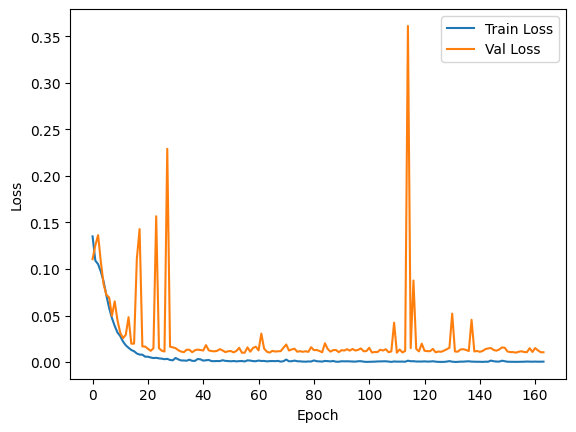

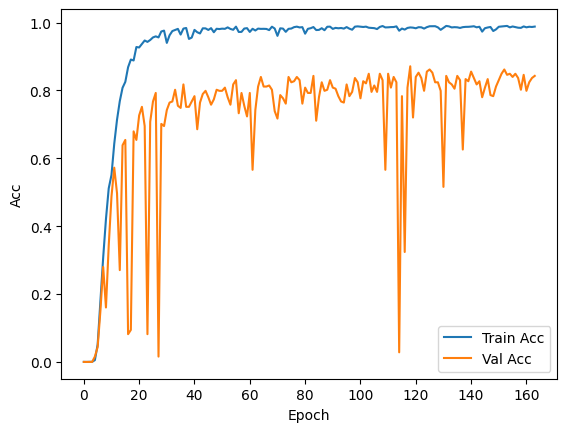

In [ ]:
# Plot the loss and acc for train and validation in soft dataset
plotLossAcc(hist_train, hist_val)

In [ ]:
# Load best model for soft dataset
model.load_state_dict(torch.load('best_model_soft.pt'))

<All keys matched successfully>

In [ ]:
# Evaluate model in soft dataset
acc, _ = evaluate(model, dl_soft_test, loss_fn, device)
acc

0.8428770949720671

In [ ]:
# Get predication for soft dataset
y_true, y_pred = getPredications(model, dl_soft_test, device)

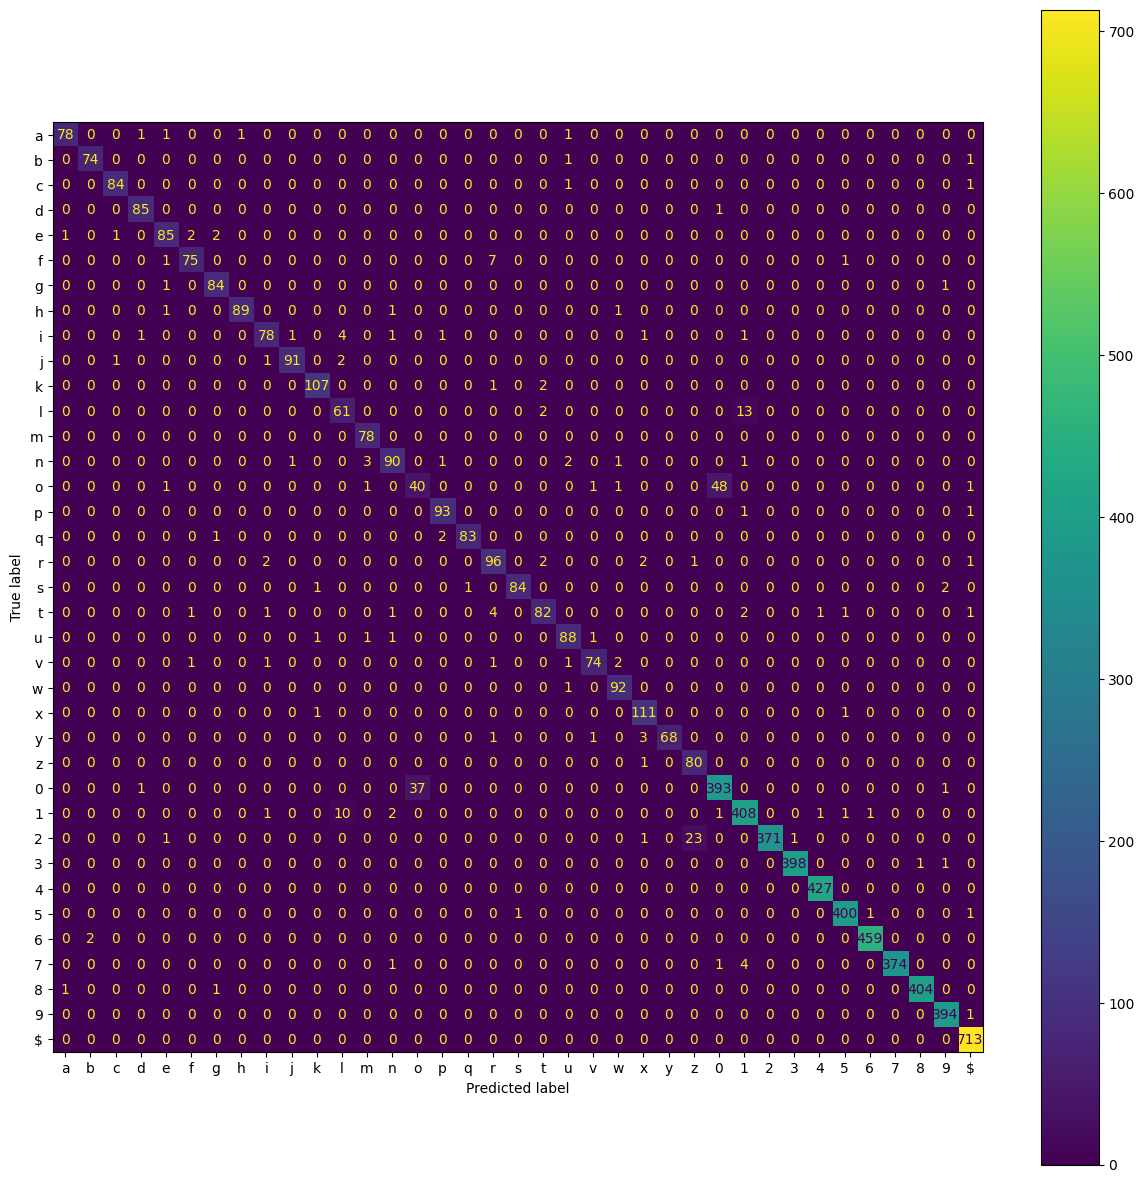

In [ ]:
# Get confusion matrix and show for soft dataset
confusion_matrix = confusionMatrix(y_true, y_pred)

In [ ]:
# Get results per each class
results_per_class = getMetrics(confusion_matrix)

In [ ]:
import pandas as pd

# Show results per class using pandas dataframe
data = {'Precision': results_per_class[0], 
        'Recall': results_per_class[1],
        'F1_score': results_per_class[2]}

df_results = pd.DataFrame(data, index = list(characters)) 
display(df_results)
print("Total accuracy in the context of characters: ", results_per_class[3])

,Precision,Recall,F1_score
a,0.951220,0.975000,0.962963
b,0.973684,0.973684,0.973684
c,0.976744,0.976744,0.976744
d,0.988372,0.965909,0.977011
e,0.934066,0.934066,0.934066
f,0.892857,0.949367,0.920245
g,0.976744,0.954545,0.965517
h,0.967391,0.988889,0.978022
i,0.886364,0.928571,0.906977
j,0.957895,0.978495,0.968085


Total accuracy in the context of characters:  0.9624301675977653


### Hard dataset

In [ ]:
model = CNN(max_captcha * characters_len)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
hist_train, hist_val = train_evaluate(model = model, 
                                      dataloader_train = dl_hard_train, 
                                      dataloader_val = dl_hard_validation, 
                                      loss_fn = loss_fn, 
                                      optimizer = optimizer, 
                                      device = device, 
                                      epochs = 200, 
                                      name_file = 'best_model_hard.pt')

Epoch: 1 | Acc train: 0.0 | Loss train: 0.14145190596935295 | Acc val: 0.0 | Loss val: 0.10960310494836564 | Acc val max: 0.0 

Epoch: 2 | Acc train: 0.0 | Loss train: 0.10968122187824476 | Acc val: 0.0 | Loss val: 0.10941425397623554 | Acc val max: 0.0 

Epoch: 3 | Acc train: 0.00018601190476190475 | Loss train: 0.1071597385619368 | Acc val: 0.0 | Loss val: 0.10507944573783201 | Acc val max: 0.0 

Epoch: 4 | Acc train: 0.0 | Loss train: 0.10365000225248791 | Acc val: 0.0 | Loss val: 0.09970600506810755 | Acc val max: 0.0 

Epoch: 5 | Acc train: 0.0005580357142857143 | Loss train: 0.09443017086457639 | Acc val: 0.0 | Loss val: 0.1017014444427229 | Acc val max: 0.0 

Epoch: 6 | Acc train: 0.014508928571428572 | Loss train: 0.08126005894016652 | Acc val: 0.0 | Loss val: 0.15057857151640178 | Acc val max: 0.0 

Epoch: 7 | Acc train: 0.0859375 | Loss train: 0.06704824799228282 | Acc val: 0.12367491166077739 | Loss val: 0.06205876467769222 | Acc val max: 0.12367491166077739 

Epoch: 8 | Acc

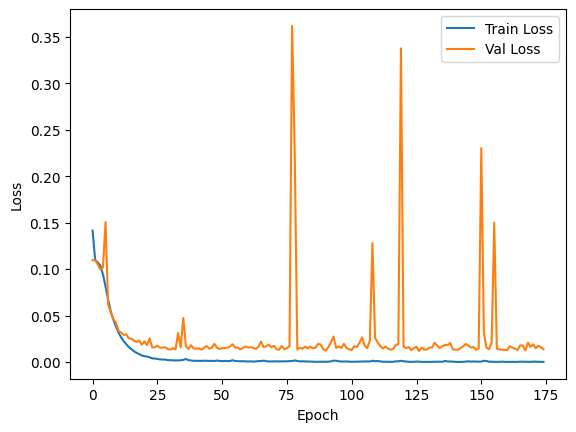

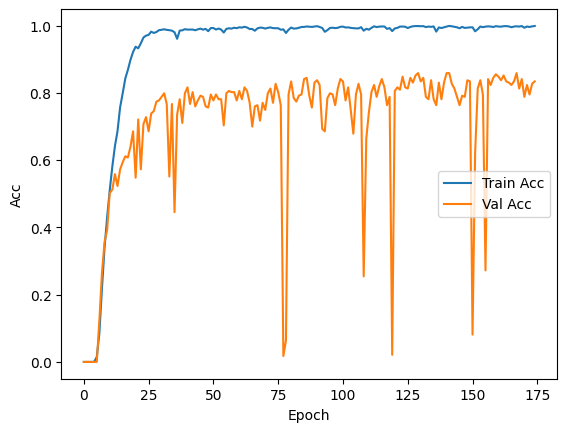

In [ ]:
# Plot the loss and acc for train and validation in hard dataset
plotLossAcc(hist_train, hist_val)

In [ ]:
# Load best model for hard dataset
model.load_state_dict(torch.load('best_model_hard.pt'))

<All keys matched successfully>

In [ ]:
# Evaluate model in hard dataset
acc, _ = evaluate(model, dl_hard_test, loss_fn, device)
acc

0.834612700628053

In [ ]:
# Get predication for hard dataset
y_true, y_pred = getPredications(model, dl_hard_test, device)

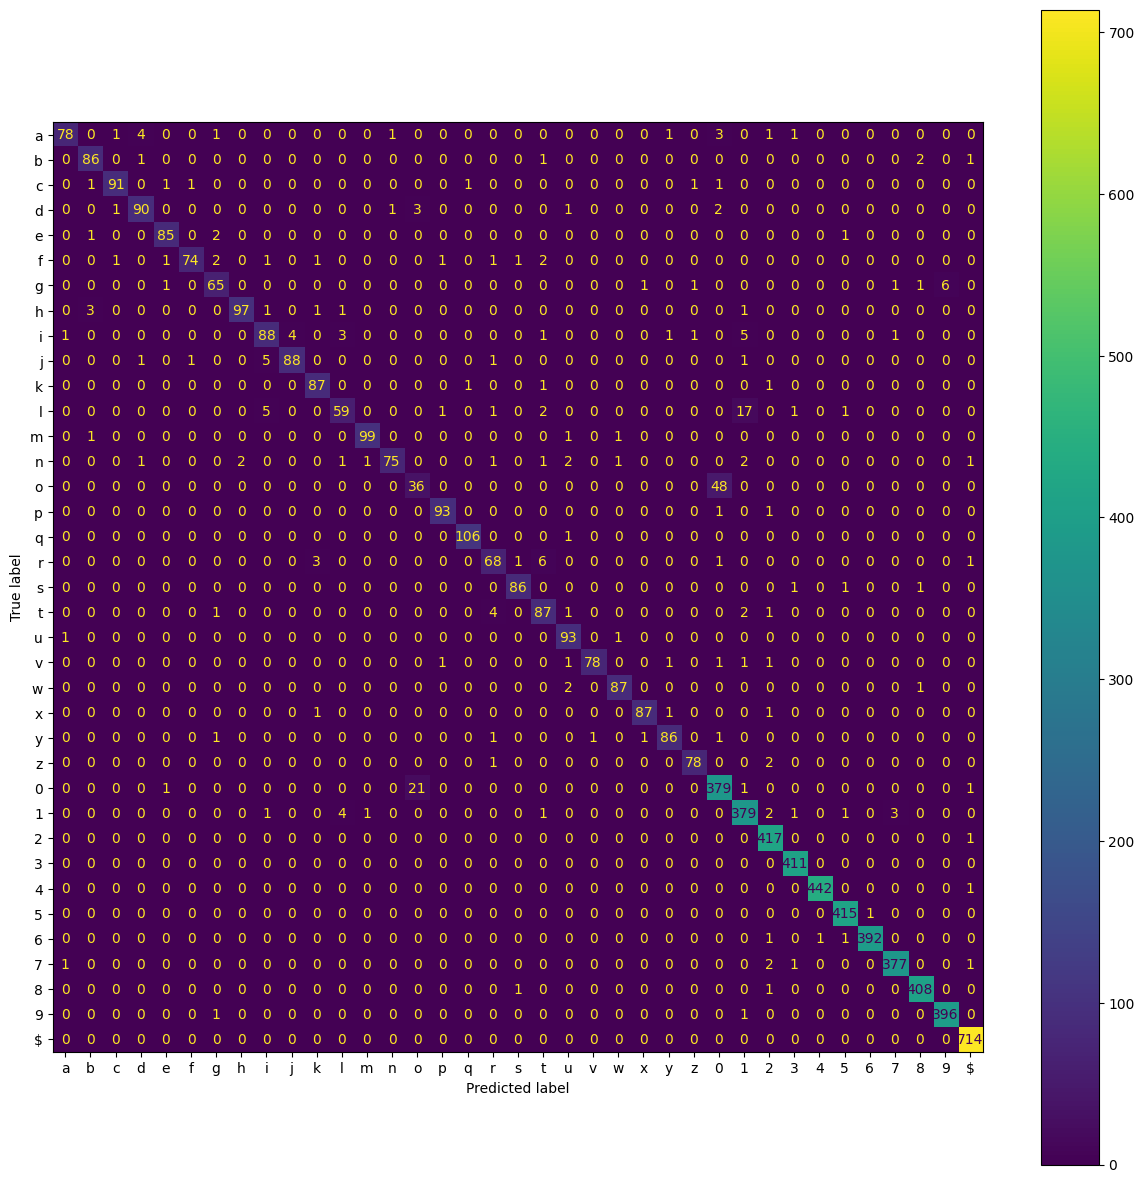

In [ ]:
# Get confusion matrix and show for hard dataset
confusion_matrix = confusionMatrix(y_true, y_pred)

In [ ]:
# Get results per each class
results_per_class = getMetrics(confusion_matrix)

In [ ]:
# Show results per class using pandas dataframe
data = {'Precision': results_per_class[0], 
        'Recall': results_per_class[1],
        'F1_score': results_per_class[2]}

df_results = pd.DataFrame(data, index = list(characters)) 
display(df_results)
print("Total accuracy in the context of characters: ", results_per_class[3])

,Precision,Recall,F1_score
a,0.857143,0.962963,0.906977
b,0.945055,0.934783,0.939891
c,0.938144,0.968085,0.952880
d,0.918367,0.927835,0.923077
e,0.955056,0.955056,0.955056
f,0.870588,0.973684,0.919255
g,0.855263,0.890411,0.872483
h,0.932692,0.979798,0.955665
i,0.838095,0.871287,0.854369
j,0.907216,0.956522,0.931217


Total accuracy in the context of characters:  0.959804605722261


### Combination dataset

In [ ]:
model = CNN(max_captcha * characters_len)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
hist_train, hist_val = train_evaluate(model = model, 
                                      dataloader_train = dl_comb_train, 
                                      dataloader_val = dl_comb_validation, 
                                      loss_fn = loss_fn, 
                                      optimizer = optimizer, 
                                      device = device, 
                                      epochs = 200, 
                                      name_file = 'best_model_comb.pt')

Epoch: 1 | Acc train: 0.0 | Loss train: 0.12333663136765943 | Acc val: 0.0 | Loss val: 0.12219371249939558 | Acc val max: 0.0 

Epoch: 2 | Acc train: 8.729050279329609e-05 | Loss train: 0.10514319983607563 | Acc val: 0.0 | Loss val: 0.10053700420652174 | Acc val max: 0.0 

Epoch: 3 | Acc train: 0.007070530726256984 | Loss train: 0.08751003319324728 | Acc val: 0.016638935108153077 | Loss val: 0.07916130497431795 | Acc val max: 0.016638935108153077 

Epoch: 4 | Acc train: 0.16262220670391062 | Loss train: 0.06111687896304956 | Acc val: 0.17970049916805325 | Loss val: 0.05722804005085777 | Acc val max: 0.17970049916805325 

Epoch: 5 | Acc train: 0.3707227653631285 | Loss train: 0.04370942814847943 | Acc val: 0.23960066555740434 | Loss val: 0.050073126817552896 | Acc val max: 0.23960066555740434 

Epoch: 6 | Acc train: 0.49677025139664804 | Loss train: 0.03267314748099729 | Acc val: 0.019966722129783693 | Loss val: 0.12974769041599232 | Acc val max: 0.23960066555740434 

Epoch: 7 | Acc tra

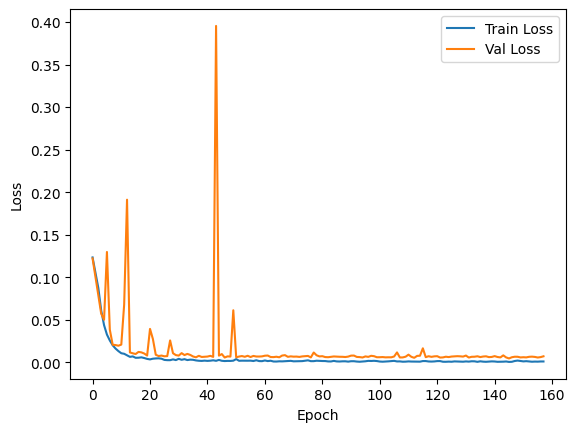

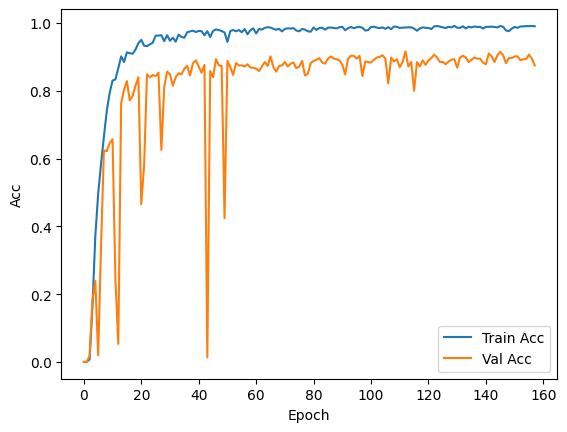

In [ ]:
# Plot the loss and acc for train and validation in hard dataset
plotLossAcc(hist_train, hist_val)

In [ ]:
# Load best model for combination dataset
model.load_state_dict(torch.load('best_model_comb.pt'))

<All keys matched successfully>

In [ ]:
# Evaluate model in soft and hard test dataset
acc_soft, _ = evaluate(model, dl_soft_test, loss_fn, device)
acc_hard, _ = evaluate(model, dl_hard_test, loss_fn, device)

print("Acc soft:", acc_soft)
print("Acc hard:", acc_hard)

Acc soft: 0.9106145251396648
Acc hard: 0.9120725750174459


In [ ]:
# Get predication for soft and hard test dataset
y_true_soft, y_pred_soft = getPredications(model, dl_soft_test, device)
y_true_hard, y_pred_hard = getPredications(model, dl_hard_test, device)

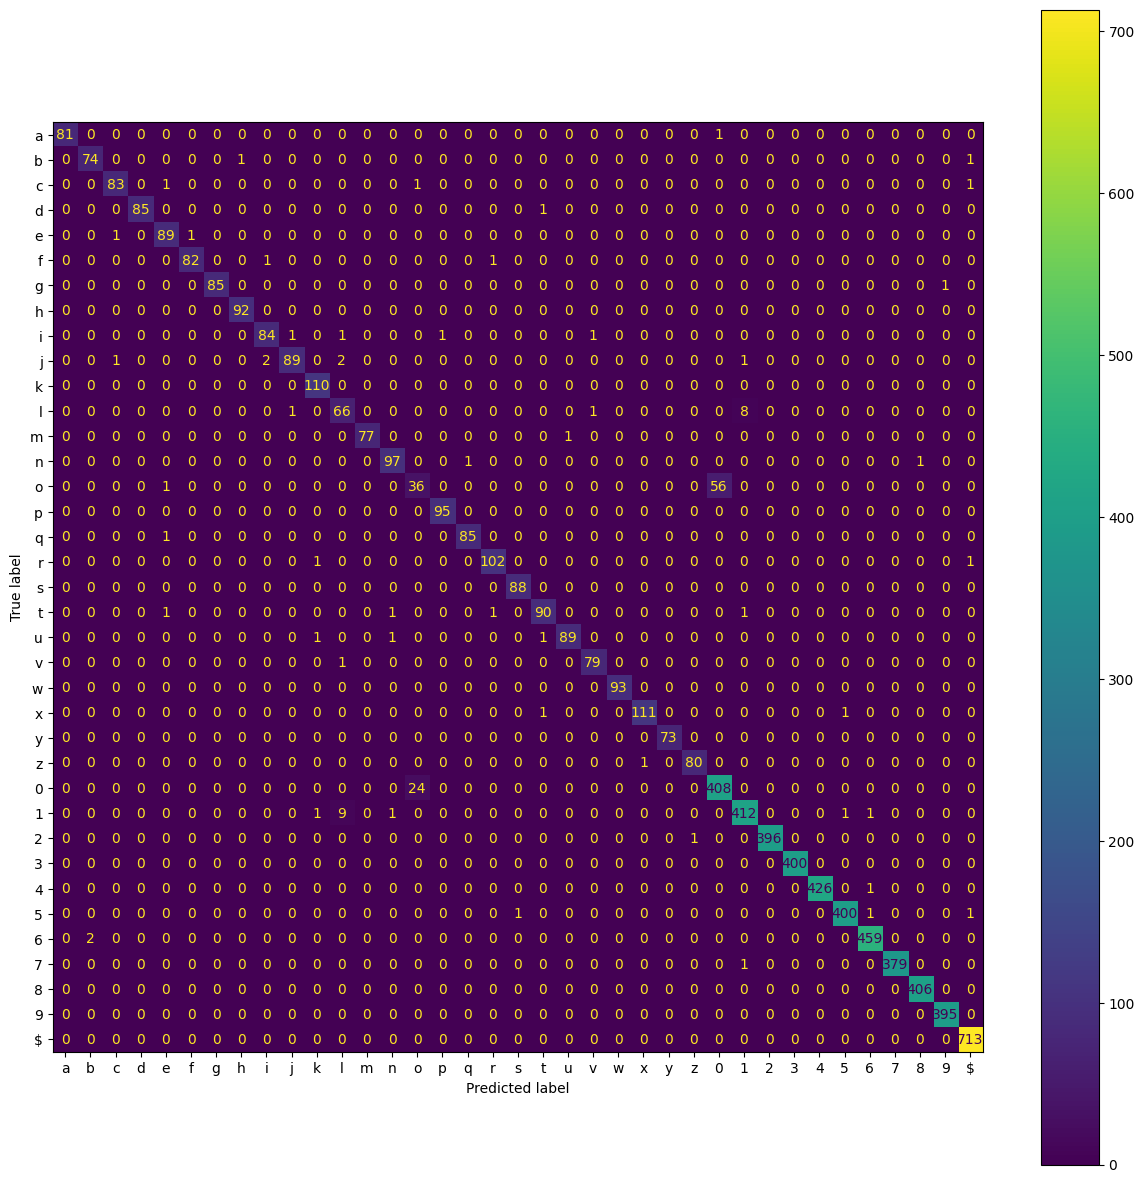

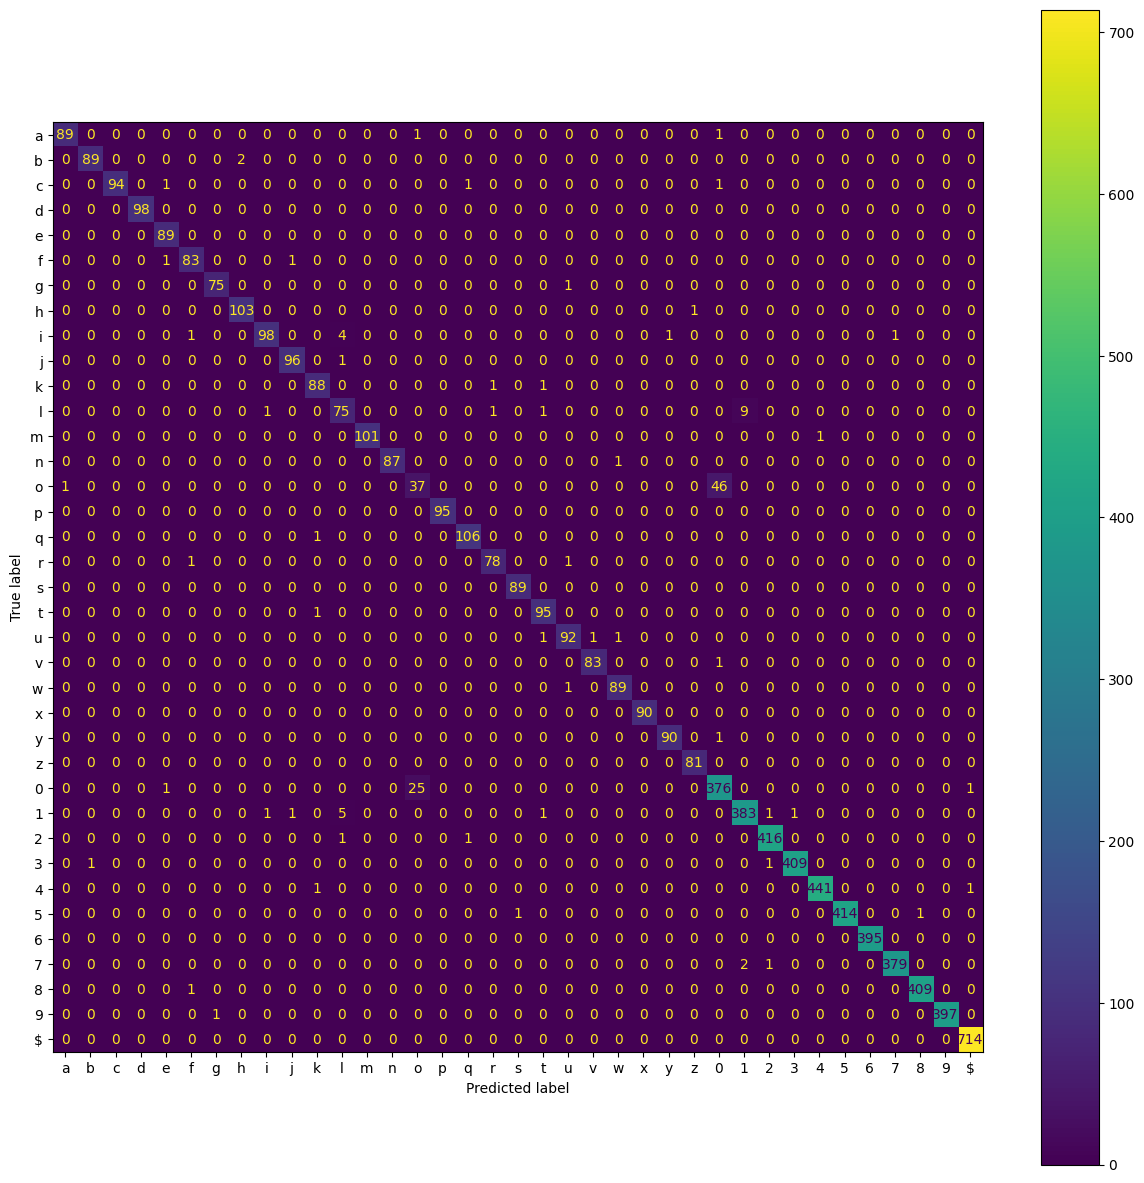

In [ ]:
# Get confusion matrix and show for hard dataset
confusion_matrix_soft = confusionMatrix(y_true_soft, y_pred_soft)
confusion_matrix_hard = confusionMatrix(y_true_hard, y_pred_hard)

In [ ]:
# Get results per each class
results_per_class_soft = getMetrics(confusion_matrix_soft)
results_per_class_hard = getMetrics(confusion_matrix_hard)

In [ ]:
# Show results per class using pandas dataframe
data = {'Precision': results_per_class_soft[0], 
        'Recall': results_per_class_soft[1],
        'F1_score': results_per_class_soft[2]}

df_results_soft = pd.DataFrame(data, index = list(characters)) 
display(df_results_soft)
print("Total accuracy in the context of characters: ", results_per_class[3])

,Precision,Recall,F1_score
a,0.987805,1.000000,0.993865
b,0.973684,0.973684,0.973684
c,0.965116,0.976471,0.970760
d,0.988372,1.000000,0.994152
e,0.978022,0.956989,0.967391
f,0.976190,0.987952,0.982036
g,0.988372,1.000000,0.994152
h,1.000000,0.989247,0.994595
i,0.954545,0.965517,0.960000
j,0.936842,0.978022,0.956989


Total accuracy in the context of characters:  0.959804605722261


In [ ]:
# Show results per class using pandas dataframe
data = {'Precision': results_per_class_hard[0], 
        'Recall': results_per_class_hard[1],
        'F1_score': results_per_class_hard[2]}

df_results_hard = pd.DataFrame(data, index = list(characters)) 
display(df_results_hard)
print("Total accuracy in the context of characters: ", results_per_class_hard[3])

,Precision,Recall,F1_score
a,0.978022,0.988889,0.983425
b,0.978022,0.988889,0.983425
c,0.969072,1.000000,0.984293
d,1.000000,1.000000,1.000000
e,1.000000,0.967391,0.983425
f,0.976471,0.965116,0.970760
g,0.986842,0.986842,0.986842
h,0.990385,0.980952,0.985646
i,0.933333,0.980000,0.956098
j,0.989691,0.979592,0.984615


Total accuracy in the context of characters:  0.9801814375436148


## Result Analysis

In this case, we will initially analyze using only the original soft and hard datasets and then the combination of both.

Starting with the soft set, an overall accuracy of 0.843 was achieved and for each character, it was 0.962, which represents an acceptable rate given the difficulty of the task. While for the hard set, it was 0.835 and for each character, it was 0.959, slightly lower due to the greater difficulty of the captchas.

In all sets, it can be seen through the confusion matrix that the main challenge of the model is to distinguish the characters ('o' and '0'), ('l' and '1'), as they are really similar and their distinction is not so simple. This can also be noted by the lower precision, recall, and f1-score for these characters.

After that, I used the approach of combining the soft and hard datasets to have more training and validation instances and try to obtain a more robust model. The result was really surprising, where the overall accuracy was increased to 0.911 for soft and hard test datasets, representing a significant improvement. In addition, the accuracy for the characters was 0.959 for soft test dataset and 0.980 for hard test dataset.

It is noted that this is also a complex task because an error in a single character of the captcha already makes it incorrect. Therefore, the overall accuracy of the model will always be lower than the accuracy for the characters.

Thus, it is noted that with a larger number of data, the model can generalize better and capture the nuances of the problem. And the model was able to identify the number of digits in each captcha accurately.

## Attempts

I made several attempts to improve the model's performance and how to approach them.

- The first attempt was simply using the division of the captcha into 5 equal spaces, but it didn't work well since the letters of the captcha were not equidistant.

- I tried to segment the letters and then use a CNN that would receive each digit and classify the captcha. However, I used traditional segmentation methods, such as using HSV and binarization with threshold in both cases using some filters to try to improve segmentation. It worked well for most captchas, but those with overlapping had a big problem. At first, I tried to divide these overlapping cases in half, but since the letters did not necessarily have the same size, it did not work so well, so I gave up on this approach. Moreover, I used thinning techniques such as Zhang-Suen, but it did not achieve result.

- After that, I moved on to the current approach using only the CNN itself. I tested using binarization, normalization, and some image filters, but at first, there was no improvement in the model, so I removed them to save computational resources.

- Then I did several tests on CNN networks, and the one that performed the best was the one I'm currently using based on the ResNet. During this process, I tested different network parameters, such as the number of residual blocks, kernel size, number of convolutions, etc. I also tried other loss functions and optimizers.

- Regarding data augmentation, I tried using some PyTorch techniques, but the one that performed the best was RandomPerspective.

## Limitations

The approach I used has a significant limitation since it does not work for a generic captcha of any size N. The model needs to know the maximum number of characters in the captcha.

Furthermore, even assuming that the maximum number of digits in the captcha is known, there would be a significant problem. For each additional digit added, there would be 37 more elements in the output vector, greatly increasing the dimensionality and consequently making it difficult for the network to converge.

## Conclusion


We noticed that the model has limitations, as described earlier, but for the proposed problem of captchas with 4 or 5 characters, the model performed satisfactorily. For better accuracy, the hyperparameters and network architecture could be explored further, as well as using pre-trained networks.

Additionally, we noticed that the main error of the network is in distinguishing the characters ("0", "o") and ("l" and "i"), as they are really similar. One approach would be to obtain more examples that use these characters to obtain a better and more robust model, which would likely greatly improve performance.